In [80]:
import sys
import pathlib
from os import uname
import json

import numpy as np
import ROOT as rt
from math import ceil, floor
import numba as nb

from src.muon_system import MuonSystemAwkward
from src import CMS_lumi, tdrstyle
from src.helper_functions import alert, Table  # , canvas
from src.histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

from train_bdt import (
    create_hists,
    ROOT_ERROR_LEVEL,
    DATA_VERSION,
    LUMI,
    FN_MC,
    FN_R3,
    T2_OUT_DIR,
    T2_DATA_DIR,
    LOCAL_OUT_DIR,
    LOCAL_DATA_DIR,
    OUT_DIR,
    DATA_DIR,
    gc,
    ABCD_DTSIZE,
    ABCD_DPHI,
    TOP_MARGIN,
    BOT_MARGIN,
    CUTS,
)

# from sklearn.metrics import roc_auc_score  # , roc_curve
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingClassifier  # , RandomForestClassifier



# **************************** #
if "TIER2" in DATA_DIR:
    OUT_DIR = f"{T2_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{T2_DATA_DIR}/MC_Summer22EE/v1/sixie/v{DATA_VERSION}/normalized/{FN_R3}.root"
    FN_R3 = f"{T2_DATA_DIR}/Data2022/v{DATA_VERSION}/normalized/{FN_R3}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.rdf" #! BROKEN
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.rdf" #! BROKEN
else:
    OUT_DIR = f"{LOCAL_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{LOCAL_DATA_DIR}/{FN_MC}_v{DATA_VERSION}.root"
    FN_R3 = f"{LOCAL_DATA_DIR}/{FN_R3}_v{DATA_VERSION}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.rdf"
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.rdf"

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
# **************************** #
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
# rt.gROOT.SetBatch(True)
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
# **************************** #

In [81]:
ABCD_DPHI = 2.75
ABCD_DTSIZE = 90
print(f"{ABCD_DPHI=}\n{ABCD_DTSIZE=}")

ABCD_DPHI=2.75
ABCD_DTSIZE=90


In [82]:
N_EVENTS = -1
CUTS = [
    "match",
    "HLT", #! Loading TBranch HLTDecision causes memory overflow so I use second precut TTree
    # "CSC&DT>0",
    "L1",
    "CSCIT",
    "DTIT",
    # "MET",
    # "ME11/12",
    "MB1",
    "JET",
    # "MUON",
    # "BDT",
    "HALO",
    # "CSCSIZE",
    "DTSTN",
    "1CSC1DT",
    # "BLINDSR",
    # "DR",
    "DPHI",
]

if "HLT" in CUTS:
    ff_mc, ff_r3 = FN_MC, FN_HLT_R3
else:
    ff_mc, ff_r3 = FN_MC, FN_R3

# **** #

ms_mc = MuonSystemAwkward(ff_mc, tree_name="MuonSystem", name="Signal", nev=N_EVENTS, is_mc=True, lumi=LUMI)
ms_r3_dtit = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT IT", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_r3_dtoot = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT OOT", nev=N_EVENTS, is_mc=False, lumi=LUMI)

# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Muon Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Muon Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Jet Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Jet Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)

mss = [ms_mc, ms_r3_dtit]
# mss = [ms_mc, ms_r3_dtoot]
# mss = [ms_mc, ms_r3_dtit, ms_r3_dtoot]

# **** #
print("")
names = [ms.name for ms in mss]
for ims, ms in enumerate(mss):
    # !!! #
    ms.cut = False
    # !!! #
    msn, is_mc = ms.name.lower(), ms.is_mc
    for cut in CUTS:
        match cut:
            case "match":
                if is_mc:
                    ms.match_mc("csc,dt", has_clusters=True)
            case "HLT":
                # if not is_mc:
                #     ms.cut_hlt()
                pass  #! Loading TBranch HLTDecision causes memory overflow so I use second precut TTree
            case "CSC&DT>0":
                ms.f((ms["nCsc"] > 0) & (ms["nDt"] > 0))
            case "L1":
                ms.cut_l1()
            case "CSCIT":
                ms.cut_time("csc", invert="csc oot" in msn)
            case "DTIT":
                ms.cut_time("dt", invert="dt oot" in msn)
            case "MET":
                ms.f(ms["met"] > 200)
            case "ME11/12":
                ms.f(
                    ms["cscNRechitChamberPlus11"]
                    + ms["cscNRechitChamberMinus11"]
                    + ms["cscNRechitChamberPlus12"]
                    + ms["cscNRechitChamberMinus12"]
                    == 0,
                    "csc",
                )
            case "MB1":
                ms.f(ms["dtNHitStation1"] == 0, "dt")
            case "JET":
                # ms.cut_jet("csc,dt")
                ms.cut_jet("csc,dt")#, csc_pt=150, dt_pt=10)
                # ms.cut_jet("dt")
            case "MUON":
                ms.cut_muon("csc,dt")
            case "BDT":
                pass
            case "HALO":
                ms.cut_halo(invert=False)  #! HALO CUT
            case "CSCSIZE":
                # ms.f(ms["cscSize"] > 250, "csc")
                ms.f(ms["cscSize"] > 200, "csc")
            case "DTSIZE":
                ms.f(ms["dtSize"] < 200, "dt")
            case "CSCSTN":
                ms.f(ms["cscSize"] > 250, "csc")
            case "DTSTN":
                ms.f((ms["dtNStation10"] < 3) & ~((ms["dtNStation10"] == 2) & (ms["dtMaxStation"] == 4)), "dt")
            case "1CSC1DT":
                ms.tag(tags="cscdt")
            case "BLINDSR":
                if not is_mc:
                    ms.f((ms["dtSize"] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI), "dt")
            case "DR":
                ms.f(ms["tag_dR"] > 0.5)
            case "DPHI":
                ms.f(ms["tag_dPhi"] > 0.4, invert=False)

    # !!! #
    ms.cut = True
    # !!! #

    ms.colors = [std_color_list[ims], std_color_list[len(mss) + ims]]
    print(f"{ms.name:>{max([len(n) for n in names])}} : {ms.count():,.1f} events")

# **** #
weights = [np.asarray(ms["weight"]) for ms in mss]
colors = [ms.colors[0] for ms in mss]
blind_conds = [
    np.ones_like(ms["tag_dPhi"], dtype=bool) if ms.is_mc else (ms["dtSize"][:, 0] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI)
    for ms in mss
]

Building MuonSystemAwkward 'Signal' -
  is_mc  = True
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/LLP/mdc_analysis/data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'


  Extracted 1,851,400 events
Building MuonSystemAwkward 'Data, DT IT' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem_HLT569'
  file   = '/home/psimmerl/LLP/mdc_analysis/data/raw/../processed/r3_hlt569.rdf'
  Extracted 1,038,214 events

     Signal : 954.4 events
Data, DT IT : 47.0 events


In [83]:
# # bins, log, norm = [20,0, 5], False, True
# # axis_titles = ["|dR_{CSC,DT}|", f"{'fraction of ' if norm else ''}events"]
# # values = [ms["tag_dR"] for ms in mss]

# # _v, _n, _w, _c = values, names, weights, colors
# # canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
# # canvas.Draw()

# # # nbins = int(np.sqrt(mss[-1].count()))
# # # bins, log, norm = [nbins, 0, np.pi, nbins,0, 5], False, True
# # # # bins, log, norm = [10, 0, np.pi, 10,0, 5], False, True
# # # axis_titles = ["|d#phi_{CSC,DT}|", "|dR_{CSC,DT}|", f"{'fraction of ' if norm else ''}events"]
# # # values = [np.c_[ms["tag_dR"],ms["tag_dPhi"]] for ms in mss]

# # # _v, _n, _w, _c = values, names, weights, colors
# # # canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
# # # canvas.Draw()

# bins, log, norm = [20,20, 200], False, False
# axis_titles = ["cscJetVetoPt", f"{'fraction of ' if norm else ''}events"]
# values = [ms["cscJetVetoPt"] for ms in mss]

# _v, _n, _w, _c = values, names, weights, colors
# canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
# canvas.Draw()

In [84]:
from scipy.optimize import curve_fit, minimize

def find_CI_limit(signal, observed, Z=2, do_verbose=False):
    # def flimit(x, pn, pb, pc, pd): #! x[0] = Z
    #     pv = np.array([pb*pd/pc, pb, pc, pd])
    #     pe = np.sqrt(pv)
    #     pe[0] = pv[0] * np.sqrt(np.sum((pe[1:]/pv[1:])**2))

    #     _out = x/pn + pv # obs = sig + bkg
    #     _out[0] = (x[0]/pn) / pe[0]

    #     return _out
    def flimit(x):
        pn, pv, pe = x[0], x, np.sqrt(x)
        pv[0] = np.array(pv[1]*pv[3]/pv[2])
        pe[0] = pv[0] * np.sqrt(np.sum((pe[1:]/pv[1:])**2))

        loss = (obs - (sig/pn + pv))/np.sqrt(obs_e**2 + (sig_e/pn)**2)
        loss[0] = (sig[0]/pn)/pe[0] - Z

        return np.sum(loss**2)

    ##
    sig, obs = np.asarray(signal).astype(float), np.asarray(observed).astype(float)
    sig_e, obs_e = sig * 0.2, np.sqrt(obs)
    ##
    p0 = np.array([np.sum(sig)/np.sum(obs), *obs[1:]])
    bounds = [(o/1000,1.2*o) for o in obs]
    bounds[0] = (1, None)
    ##
    res = minimize(flimit, p0, bounds=bounds)
    limit, pars = 1/res.x[0], res.x
    pars[0] = pars[1]*pars[3]/pars[2]

    par_errs = np.diag(res.hess_inv.todense())#np.ones_like(pars)
    limit_err = par_errs[0] 
    par_errs = pars[0] * np.sqrt(np.sum((par_errs[1:]/pars[1:])**2))

    if do_verbose:
        print("|   |    Obs | FitBkg |    Sig |")
        print("|---+--------+--------+--------+")
        print(f"| A | {obs[0]:6.2f} | {pars[0]:6.2f} | {limit*sig[0]:6.2f} |")
        print(f"| B | {obs[1]:6.2f} | {pars[1]:6.2f} | {limit*sig[1]:6.2f} |")
        print(f"| C | {obs[2]:6.2f} | {pars[2]:6.2f} | {limit*sig[2]:6.2f} |")
        print(f"| D | {obs[3]:6.2f} | {pars[3]:6.2f} | {limit*sig[3]:6.2f} |")
        print(f"Limit = {100*limit:.3f}%")

    return limit, pars, limit_err, par_errs

In [85]:
def calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind=False, g_cond=None):
    if g_cond is not None:
        a_cond, b_cond = a_cond & g_cond, b_cond & g_cond
        c_cond, d_cond = c_cond & g_cond, d_cond & g_cond
    a = 0 if blind else np.sum(weight[a_cond])
    b = np.sum(weight[b_cond])
    c = np.sum(weight[c_cond])
    d = np.sum(weight[d_cond])
    ae, be, ce, de = np.sqrt(a), np.sqrt(b), np.sqrt(c), np.sqrt(d)
    pa, pae = 0, 0

    if b * c * d > 0:
        pa, pae = b * d / c, b * d / c * ((be / b) ** 2 + (ce / c) ** 2 + (de / d) ** 2) ** 0.5
    return (pa,a,b,c,d), (pae,ae,be,ce,de)

# SIGNAL IN ABCD REGION A
abcd_sig, abcd_obs = [], []
print("SR Background Predictions from ABCD")
for ims, ms in enumerate(mss):
    dtsize, dphi = ms["dtSize"][:,0], ms["tag_dPhi"]
    a_cond = (dtsize > ABCD_DTSIZE) & (dphi > ABCD_DPHI)
    b_cond = (dtsize < ABCD_DTSIZE) & (dphi > ABCD_DPHI)
    c_cond = (dtsize < ABCD_DTSIZE) & (dphi < ABCD_DPHI)
    d_cond = (dtsize > ABCD_DTSIZE) & (dphi < ABCD_DPHI)
    vals, errs = calc_abcd(ms["weight"], a_cond, b_cond, c_cond, d_cond, blind="dt it" in ms.name.lower())
    tot, a, ae, pa, pae = np.sum(vals[2:]), vals[1], errs[1], vals[0], errs[0]

    if ims == 0:
        abcd_sig = list(vals[1:5])
        asig = vals[1]
    elif ims == 1:
        abcd_obs = list(vals[1:5])
        abcd_obs[0] = vals[0]

    print(f"{ms.name}:")#:>{max([len(n) for n in names])}} :")
    print(f"\ta = " +(f"{vals[1]:4.2f} ± {errs[1]:4.2f}" if ms.is_mc else f"{vals[0]:4.2f} ± {errs[0]:4.2f} (b*d/c)"))
    print(f"\tb = {vals[2]:4.2f} ± {errs[2]:4.2f}")
    print(f"\tc = {vals[3]:4.2f} ± {errs[3]:4.2f}")
    print(f"\td = {vals[4]:4.2f} ± {errs[4]:4.2f}")

Z, verbose = 2, True
sig, obs = np.asarray(abcd_sig), np.asarray(abcd_obs)
lm, pp, le, pe = find_CI_limit(sig, obs, Z=Z, do_verbose=verbose)
pae = pp[0] * np.sqrt(np.sum((np.sqrt(pp[1:])/pp[1:])**2))
assert np.sum(np.abs(obs - (lm*sig + pp))[1:]) < 1e-4

SR Background Predictions from ABCD
Signal:
	a = 313.52 ± 17.71
	b = 202.37 ± 14.23
	c = 138.34 ± 11.76
	d = 291.78 ± 17.08
Data, DT IT:
	a = 0.44 ± 0.46 (b*d/c)
	b = 1.00 ± 1.00
	c = 32.00 ± 5.66
	d = 14.00 ± 3.74
|   |    Obs | FitBkg |    Sig |
|---+--------+--------+--------+
| A |   0.44 |   0.24 |   0.66 |
| B |   1.00 |   0.57 |   0.43 |
| C |  32.00 |  31.71 |   0.29 |
| D |  14.00 |  13.39 |   0.61 |
Limit = 0.210%


NEV_SMEAR=100,000
0 39 0.6040899157524109 0.6040899157524109
1 32 2.122079336643219 3.0560273971538647
2 32 67.0 195.0
0 6 1.0 1.0
1 5 0.608090142160654 2.2426223017340954
1 0.8131231460807523
2 5 55.36 117.2
2 0.04577095208281104
 FCN=3.01048 FROM MIGRAD    STATUS=CONVERGED      43 CALLS          44 TOTAL
                     EDM=3.06683e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.91389e+00   5.42330e-01   2.33179e-04  -1.39661e-03
   2  Slope       -8.13123e-01   4.07110e-01   1.75298e-04  -5.42754e-04
                               ERR DEF= 0.5
 FCN=2.10425 FROM MIGRAD    STATUS=CONVERGED      51 CALLS          52 TOTAL
                     EDM=6.5512e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          

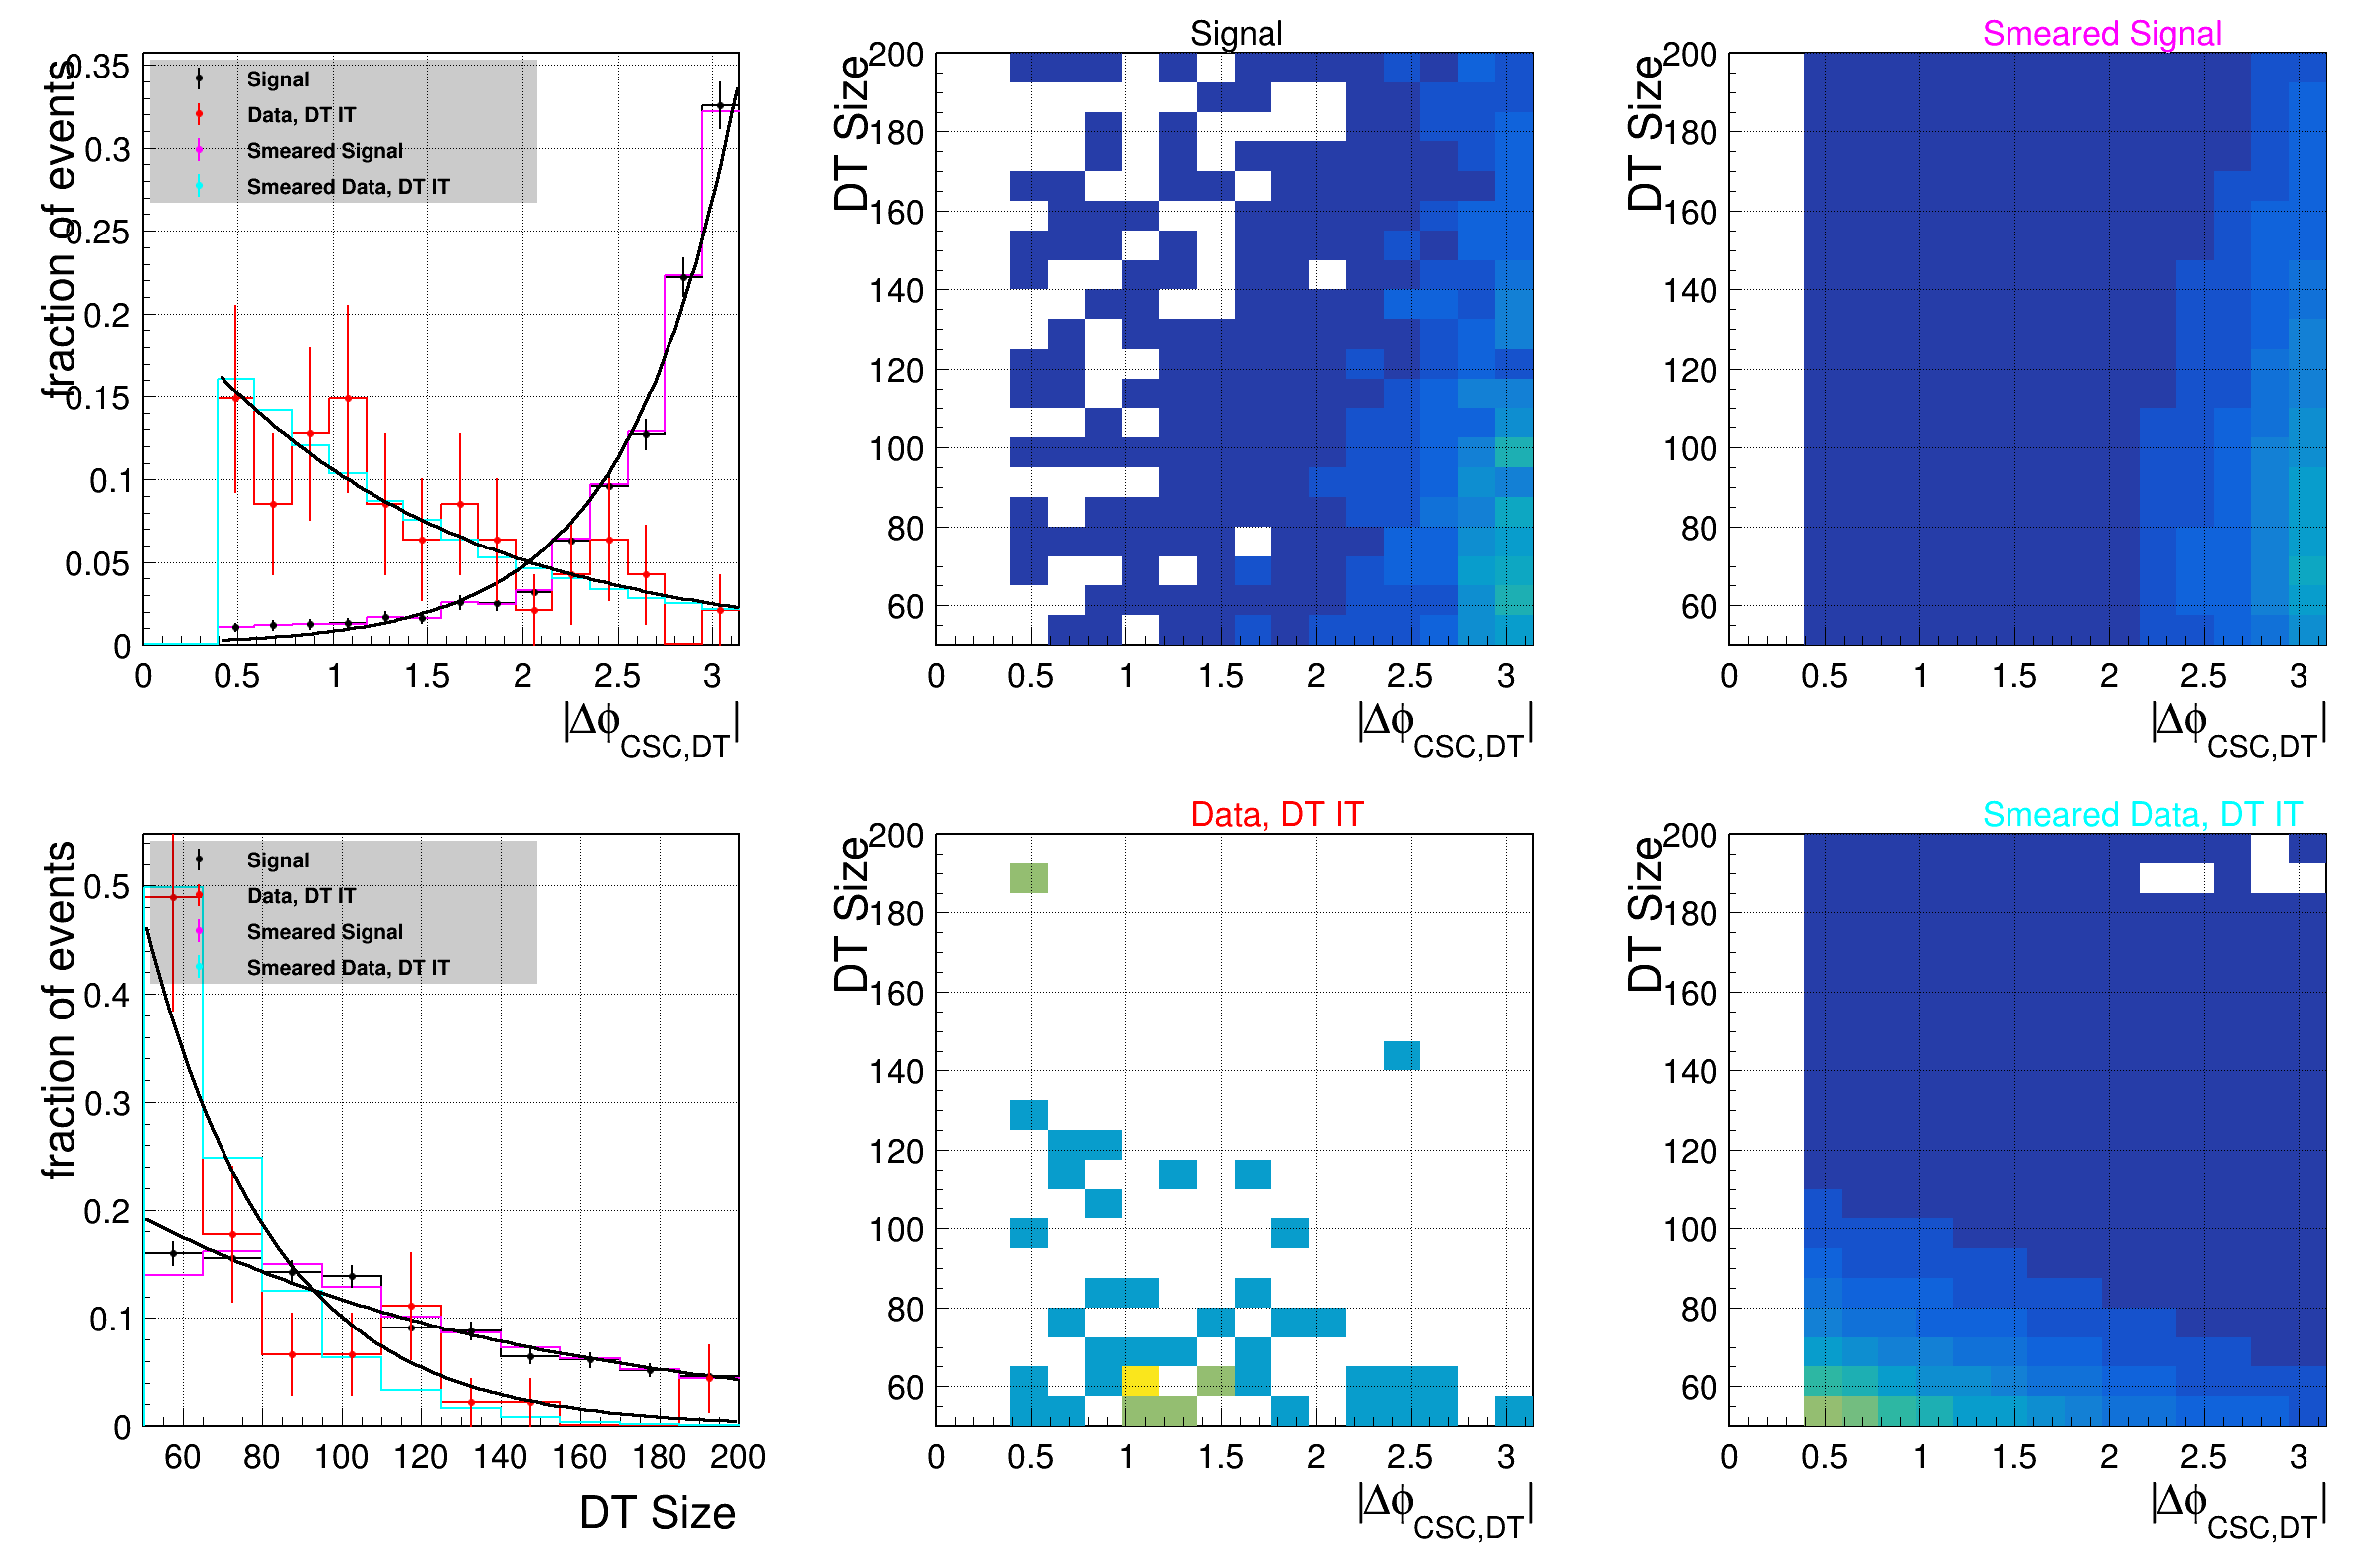

In [86]:
fits = []
def smear(*args, fit=False, bootstrap=True, size=None):
    nev = args[0].shape[0]
    # if not bootstrap and size is None:
    #     return [arg if i != 2 else np.random.normal(arg, np.sqrt(arg)) for i, arg in enumerate(args)]

    if size is None:
        size = nev
    elif size < 1000:
        size = size * nev
    size = int(size)

    if bootstrap:
        idxs = np.random.randint(0, nev, size)
    else:
        idxs = np.arange(0, size) % nev

    out = []
    for i, arg in enumerate(args):
        # nbin = max(10, int(np.sqrt(arg.shape[0])))
        # nbin = floor(np.sqrt(arg.shape[0]))
        # _min, _max = np.quantile(arg, [0.1, 0.9])
        # _min, _max = np.quantile(arg, [0.2, 0.8])
        _min, _max = np.quantile(arg, [0.16, 0.84]) # ~ +/- 1 sigma
        nbin = int(np.sqrt(np.sum((_min <= arg) & (arg <= _max))))
        print(i, nbin, _min, _max)

        RAND_NUM = f"{np.random.randint(999999999)}"
        ft = rt.TF1("fit_"+RAND_NUM, "expo", _min, _max)
        hh = rt.TH1D("hh_"+RAND_NUM, "", nbin, _min, _max)

        if i == 0:
            out.append(arg[idxs] * nev / size)
        elif i == 1:
            _out = np.array([])
            if fit:
                # ft = rt.TF1("fit_df", "expo", 0.4, np.pi)
                # hh = rt.TH1D("", "", nbin, 0.4, np.pi)
                flip = np.mean(arg) > (np.pi - 0.4) * 3/4
                # print(flip, np.mean(arg), _min, _max)
                for x in arg:
                    hh.Fill(x)
                # hh.Fit("fit_df", "RL")
                hh.Fit("fit_"+RAND_NUM, "RL")
                ww = np.abs(ft.GetParameter(1))
                print(i, ww)
                while len(_out) < size:
                    if flip:
                        _temp = np.pi - np.random.exponential(1 / ww, size)
                    else:
                        _temp = np.random.exponential(1 / ww, size) + 0.4
                    _out = np.append(_out, _temp[(0.4 <= _temp) & (_temp <= np.pi)])
            else:
                if bootstrap:
                    idxs = np.random.randint(0, nev, size)
                    # out.append(arg[idxs])
                    _out = arg[idxs]
                    # while len(_out) < size:
                    #     _temp = np.pi - np.random.exponential(1/1.76736e+00, size)
                    #     _out = np.append(_out, _temp[_temp >= 0.4])
            out.append(_out[:size])
        elif i == 2:
            if fit:
                # ft = rt.TF1("fit_sz", "expo", 50, _max)
                # hh = rt.TH1D("", "", nbin, 50, _max)
                for x in arg:
                    hh.Fill(x)
                # hh.Fit("fit_sz", "RL")
                hh.Fit("fit_"+RAND_NUM, "RL")
                ww = np.abs(ft.GetParameter(1))
                print(i, ww)
                out.append(np.random.exponential(1 / ww, size) + 50)
            else:
                if bootstrap:
                    idxs = np.random.randint(0, nev, size)
                    out.append(np.random.normal(arg[idxs], np.sqrt(arg[idxs])))
                    # out.append(arg[idxs])
                    # out.append(np.random.exponential(1/1.21694e-02, size) + 50)
        else:
            out.append(arg[idxs])
        fits.append(ft)

    return out

# *** #

NEV_SMEAR = max([100_000] + [w.shape[0] for w in weights])
print(f"{NEV_SMEAR=:,.0f}")

# values = [[np.asarray(ms["weight"]), np.asarray(ms["tag_dPhi"]), np.asarray(ms["dtSize"][:, 0])] for ms in mss]
values = []
for ms in mss:
    wt, df, sz = np.asarray(ms["weight"]), np.asarray(ms["tag_dPhi"]), np.asarray(ms["dtSize"][:,0])
    # if not ms.is_mc:
    #     wt, df, sz = wt[sz < 200], df[sz < 200], sz[sz < 200] 
    values.append([wt, df, sz])

values_smeared = [smear(*vs, fit=iv > 0, bootstrap=True, size=NEV_SMEAR) for iv, vs in enumerate(values)]

_w = [vs[0] for vs in values + values_smeared]
_df = [vs[1] for vs in values + values_smeared]
_sz = [vs[2] for vs in values + values_smeared]
_n = names + ["Smeared " + n for n in names]
_c = colors + [c + 5 for c in colors]

# *** #

_v = _df
# bins, log, norm = [32, 0, np.pi], False, True
bins, log, norm = [16, 0, np.pi], False, True
axis_titles = ["|#Delta#phi_{CSC,DT}|", f"{'fraction of ' if norm else ''}events"]
c_df, leg_df, hs_df = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

_v = _sz
# bins, log, norm = [20, 50, 200], False, True
bins, log, norm = [10, 50, 200], False, True
axis_titles = ["DT Size", f"{'fraction of ' if norm else ''}events"]
c_sz, leg_sz, hs_sz = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

_v = [np.c_[df, sz] for df, sz in zip(_df, _sz)]
bins, log, norm = [16, 0, np.pi, 20, 50, 200], False, True
axis_titles = ["|#Delta#phi_{CSC,DT}|", "DT Size", f"{'fraction of ' if norm else ''}events"]
c_2d, leg_2d, hs_2d = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# *** #

fit_sig_df = rt.TF1("fit_sig_df", "expo", 0.4, np.pi)
hs_df[0].Fit("fit_sig_df", "RL")

fit_bkg_df = rt.TF1("fit_bkg_df", "expo", 0.4, np.pi)
hs_df[1].Fit("fit_bkg_df", "RL")

fit_sig_sz = rt.TF1("fit_sig_sz", "expo", 50, 500)
hs_sz[0].Fit("fit_sig_sz", "RL")

fit_bkg_sz = rt.TF1("fit_bkg_sz", "expo", 50, 200)
hs_sz[1].Fit("fit_bkg_sz", "RL")

# *** #

RAND_NUM = f"{np.random.randint(999999999)}"
canvas = rt.TCanvas("c" + RAND_NUM, "c" + RAND_NUM, 3 * 800, 2 * 800)
canvas.Divide(3, 2)

canvas.cd(1)
canvas.cd(1).SetGrid()
canvas.cd(1).SetRightMargin(0.04)
for h in hs_df:
    h.Draw("same hist")
hs_df[0].Draw("same func")
hs_df[1].Draw("same func")
leg_df.Draw()

canvas.cd(4)
canvas.cd(4).SetGrid()
canvas.cd(4).SetRightMargin(0.04)
for h in hs_sz:
    h.Draw("same hist")
hs_sz[0].Draw("same func")
hs_sz[1].Draw("same func")
leg_sz.Draw()

lat = rt.TLatex()
for ic, ih in [[2, 0], [5, 1], [3, 2], [6, 3]]:
    canvas.cd(ic)
    canvas.cd(ic).SetGrid()
    canvas.cd(ic).SetRightMargin(0.04)
    # canvas.cd(ic).SetLogy()
    hs_2d[ih].Draw("col")
    lat.SetTextColor(hs_2d[ih].GetLineColor())
    lat.DrawLatexNDC(0.5, 0.96, hs_2d[ih].GetName().split(".")[0])

canvas.Draw()

# n_shift, qt = max([len(n) for n in _n]), 0.95
# print(f"Max Quantile = {qt}")
# for n, df, sz in zip(_n, _df, _sz):
#     print(f"{n:>{n_shift}}: {np.mean(sz)}, dtSize = {np.quantile(sz, qt):3.0f}")

NEV_SMEAR=100,000
0 39 0.6040899157524109 0.6040899157524109
1 32 2.122079336643219 3.0560273971538647
2 32 67.0 195.0
0 6 1.0 1.0
1 5 0.608090142160654 2.2426223017340954
1 0.8131231460807523
2 5 55.36 117.2
2 0.04577095208281104
 FCN=3.01048 FROM MIGRAD    STATUS=CONVERGED      43 CALLS          44 TOTAL
                     EDM=3.06683e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.91389e+00   5.42330e-01   2.33179e-04  -1.39661e-03
   2  Slope       -8.13123e-01   4.07110e-01   1.75298e-04  -5.42754e-04
                               ERR DEF= 0.5
 FCN=2.10425 FROM MIGRAD    STATUS=CONVERGED      51 CALLS          52 TOTAL
                     EDM=6.5512e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          

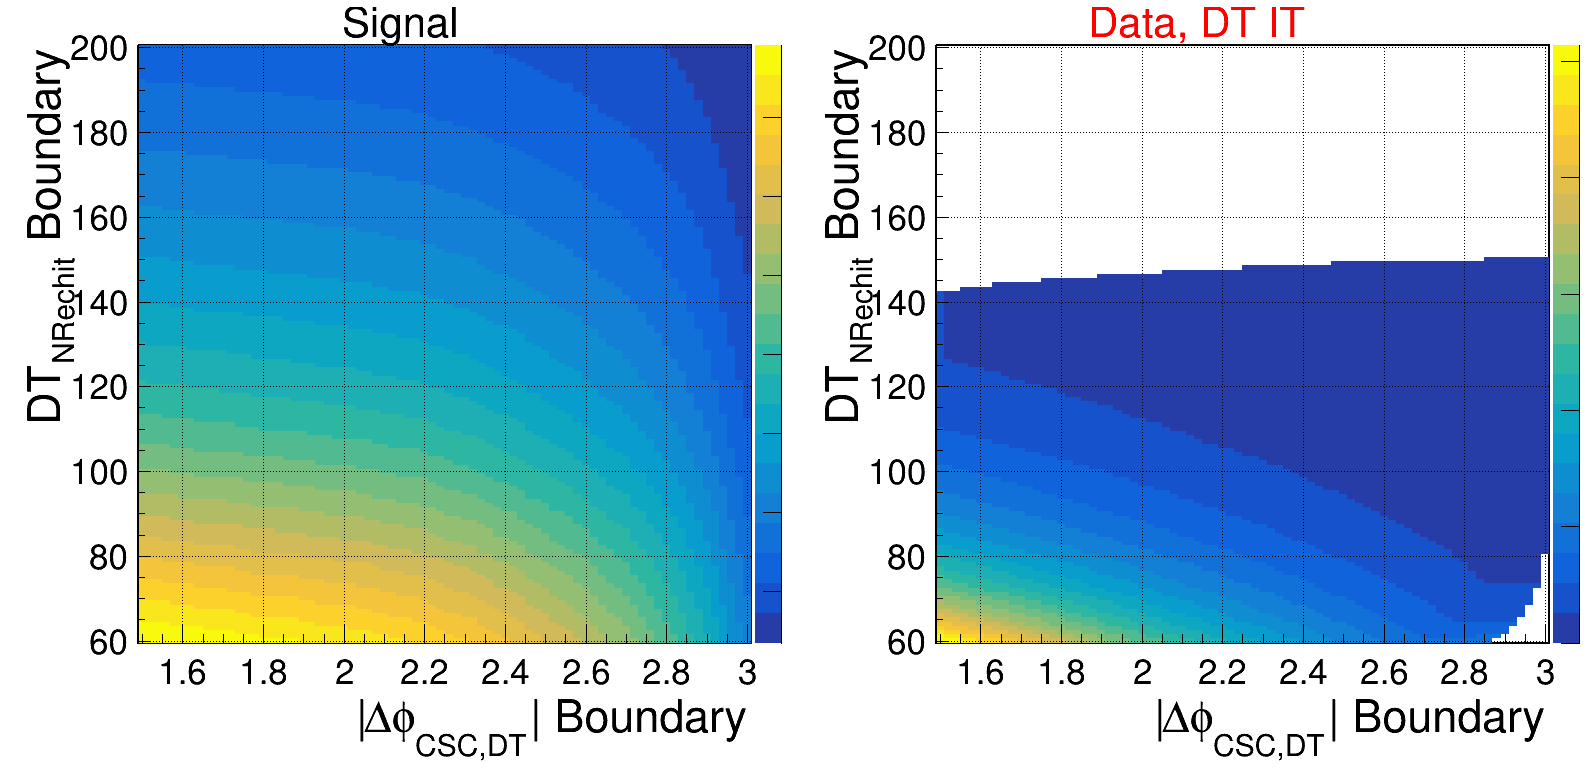

In [91]:
nth_sz, nth_df = (200-60)//1 + 1, (300-150)//5 + 1 # 31, 19
size_ths, dphi_ths = np.linspace(60, 200, nth_sz), np.linspace(1.5, 3.0, nth_df)
dth_sz, dth_df = size_ths[1]-size_ths[0], dphi_ths[1]-dphi_ths[0]
thresh_info = {}#{ms.name : [] for ms in mss}

print(f"{NEV_SMEAR=:,.0f}")

sz_conds, df_conds = [], []
for ims, ms in enumerate(mss):
    wt, df, sz = np.asarray(ms["weight"]), np.asarray(ms["tag_dPhi"]), np.asarray(ms["dtSize"][:,0])
    # if not ms.is_mc:
    #     wt, df, sz = wt[sz < 200], df[sz < 200], sz[sz < 200] 
    # wt = wt[np.random.randint(0, sz.shape[0], NEV_SMEAR)] * sz.shape[0] / NEV_SMEAR
    # df = df[np.random.randint(0, sz.shape[0], NEV_SMEAR)]
    # sz = sz[np.random.randint(0, sz.shape[0], NEV_SMEAR)]
    # sz = np.random.normal(sz, np.sqrt(sz))
    if NEV_SMEAR>0:
        wt, df, sz = smear(wt, df, sz, fit=ims>0, bootstrap=True, size=NEV_SMEAR)
    
    df_cond, sz_cond = df[None,:]>dphi_ths[:,None], sz[None,:]>size_ths[:,None]
    _abcd = np.array([[np.sum(wt[(df_cond[idf])&(sz_cond[isz])]),np.sum(wt[(df_cond[idf])&(~sz_cond[isz])]),np.sum(wt[(~df_cond[idf])&(~sz_cond[isz])]),np.sum(wt[(~df_cond[idf])&(sz_cond[isz])])] for idf in range(nth_df) for isz in range(nth_sz)]).T
    _err = np.sqrt(_abcd[0])
    
    sz_conds.append(np.sum(sz_cond,1).astype(float))
    df_conds.append(np.sum(df_cond,1).astype(float))

    _abcd[_abcd<1] = 0
    # _abcd = np.round(_abcd) 
    # _abcd[_abcd<1] = np.round(_abcd[_abcd<1]) 
    # _abcd[_abcd<1] = np.sqrt(_abcd[_abcd<1]) 
    # _abcd[_abcd<1] = np.round(np.sqrt(_abcd[_abcd<1])) 

    if not ms.is_mc:
        _abcd[0] = np.divide(_abcd[1]*_abcd[3], _abcd[2], out=np.zeros_like(_abcd[0]), where=_abcd[2]!=0)

        _idxs = (_abcd[1] * _abcd[2] * _abcd[3]) > 0
        _err[_idxs] = _abcd[0, _idxs] * np.sqrt(1/_abcd[1, _idxs] + 1/_abcd[2, _idxs] + 1/_abcd[3, _idxs])
        _err[~_idxs] = 1
    
    thresh_info[ms.name] = np.array([ [dphi_ths[idf], size_ths[isz], *_abcd[:,isz + idf*nth_sz], _err[isz + idf*nth_sz]] for idf in range(nth_df) for isz in range(nth_sz) ])


# *** #
# Event Counts
bins, log, norm = [nth_df, dphi_ths[0]-dth_df/2, dphi_ths[-1]+dth_df/2, nth_sz, size_ths[0]-dth_sz/2, size_ths[-1]+dth_sz/2], False, False
axis_titles = ["|#Delta#phi_{CSC,DT}| Boundary", "DT_{NRechit} Boundary", f"{'fraction of ' if norm else ''}SR events"]

_values = [np.asarray(thresh_info[ms.name][:,:2]) for ms in mss]
# _values += _values[1:]
_evts = [np.asarray(thresh_info[ms.name][:,2]) for ms in mss]
# _evts += _evts[1:]
_errs = [np.asarray(thresh_info[ms.name][:,-1]) for ms in mss]

_names = names + [f"{names[0]} / #sqrt{{names[i]}}" for i in range(1, len(names)-1)]
_v, _n, _w, _c = _values, _names, _evts, colors

# ims = 1
# _v, _n, _w, _c = _values[ims:ims+1], names[ims:ims+1], _evts[ims:ims+1], colors[ims:ims+1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm, share_scale=False)
canvas.Draw()

In [92]:
sz_s2b = np.divide(sz_conds[0], np.sqrt(sz_conds[1]), out=np.zeros_like(sz_conds[0]), where=sz_conds[1]>0)
sz_idx = np.argmax(sz_s2b)
print(size_ths[sz_idx], sz_conds[0][sz_idx], sz_conds[1][sz_idx], sz_s2b[sz_idx])

df_s2b = np.divide(df_conds[0], np.sqrt(df_conds[1]), out=np.zeros_like(df_conds[0]), where=df_conds[1]>0)
df_idx = np.argmax(df_s2b)
print(dphi_ths[df_idx], df_conds[0][df_idx], df_conds[1][df_idx], df_s2b[df_idx])

200.0 14870.0 120.0 1357.4390716836367
2.7 59058.0 5219.0 817.4949660664425


X | dPhi = 2.82, dtSize = 134.0 -- Limit = 0.049%, S/Sqrt[B] = 874.94, S = 170.83, B =  0.04
O | dPhi = 2.92, dtSize = 135.0 -- Limit = 0.045%, S/Sqrt[B] = 823.27, S = 126.61, B =  0.02


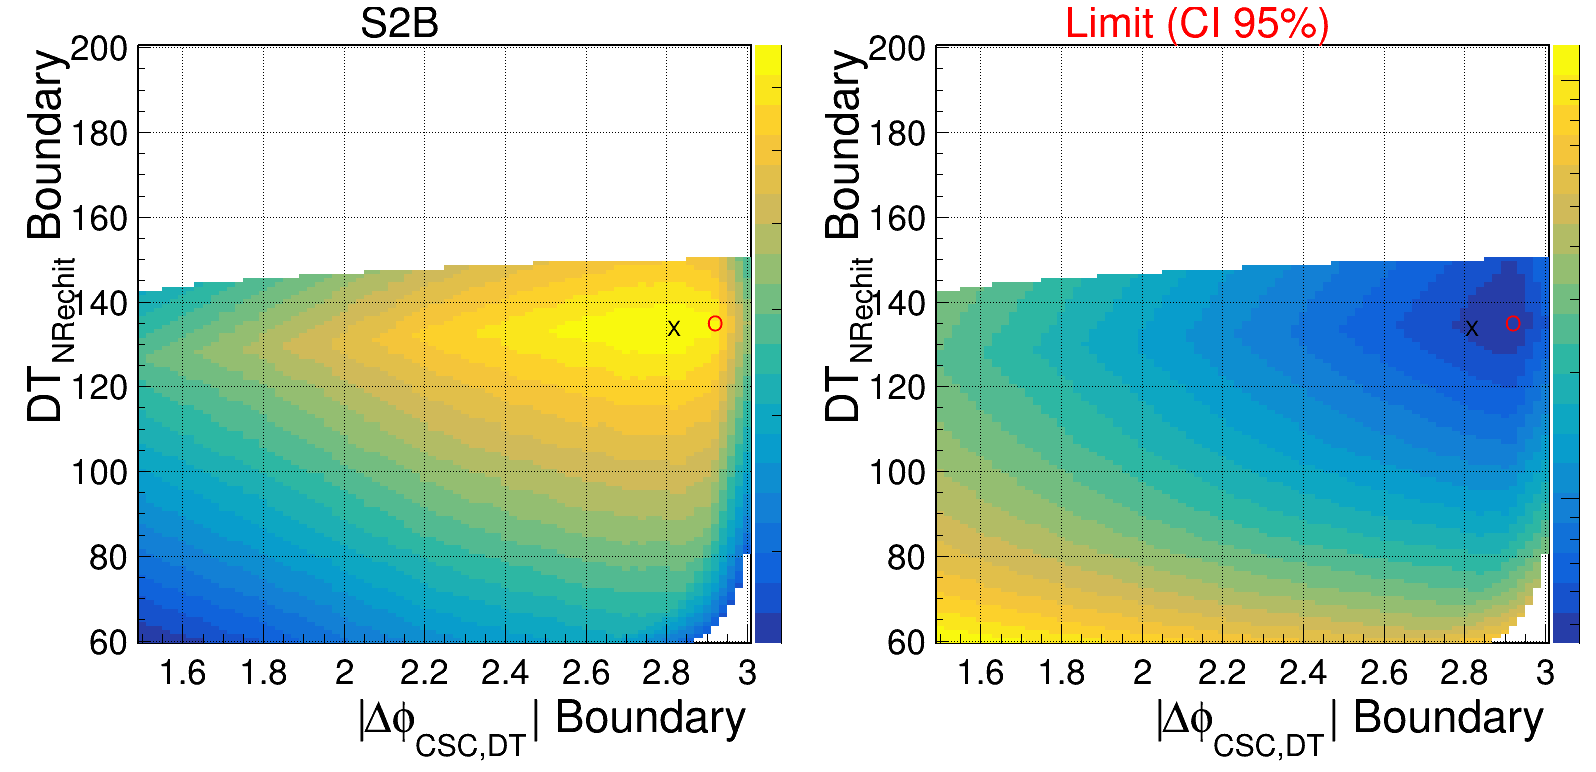

In [93]:
# S / Sqrt[ B ]
bins, log, norm = [nth_df, dphi_ths[0]-dth_df/2, dphi_ths[-1]+dth_df/2, nth_sz, size_ths[0]-dth_sz/2, size_ths[-1]+dth_sz/2], False, False
axis_titles = ["|#Delta#phi_{CSC,DT}| Boundary", "DT_{NRechit} Boundary", f"{'fraction of ' if norm else ''}"+"S / #sqrt{B}"]

_evts = [thresh_info[ms.name][:,2] for ms in mss]
idxs = _evts[1] > 0

_evts = [evts[idxs] for evts in _evts]
_values = [thresh_info[ms.name][idxs,:2] for ms in mss]
_abcd = [thresh_info[ms.name][idxs,2:6] for ms in mss]
_errs = [thresh_info[ms.name][idxs,-1] for ms in mss]

_s2b = _evts[0] / np.sqrt(_evts[1])
_lim = [find_CI_limit(sig, obs, Z=Z, do_verbose=False)[0] for sig, obs in zip(_abcd[0], _abcd[1])]

_v, _n, _c, _w = [_values[0], _values[0]], ["S2B", "Limit (CI 95%)"], [std_color_list[0], std_color_list[1]], [_s2b, _lim]
canvas, legend, hhs = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=False, norm=False)

lat, lls = rt.TLatex(), []
lat.SetTextAlign(22)
lat.SetTextSize(0.03)

for ih, hh in enumerate(hhs):
    canvas.cd(ih + 1).SetLogz()

    v, sig, bkg = _v[0], _evts[0], _evts[1]
    n, c, w = _n[ih], _c[ih], _w[ih]

    hh.SetMinimum(np.min(w))
    hh.SetMaximum(np.max(w))
    
    if ih == 0:
        idx_s2b = np.argmax(w)
        idx = idx_s2b
        m = "X"
    elif ih == 1:
        idx_lim = np.argmin(w)
        idx = idx_lim
        m = "O"

    df, sz, s, b = v[idx][0], v[idx][1], sig[idx], bkg[idx]
    s2b, lim = _s2b[idx], _lim[idx]
    lls.append((c, df, sz, f"{m} | dPhi = {df:4.2f}, dtSize = {sz:5.1f} -- Limit = {100*lim:5.3f}%, S/Sqrt[B] = {s2b:6.2f}, S = {s:6.2f}, B = {b:5.2f}"))

for ih, (n, c) in enumerate(zip(_n, _c)):
    canvas.cd(ih + 1)
    for cl, df, sz, ll in lls:
        lat.SetTextColor(cl)
        lat.DrawLatex(df, sz, ll[0])
        if ih == 0:
            print(ll)

canvas.Draw()

In [95]:
# SIGNAL IN ABCD REGION A USING BEST S2B RATIO
# ABCD_DPHI_S2B, ABCD_DTSIZE_S2B = 2.67, 121.0

for idx in [idx_s2b, idx_lim]:

    ABCD_DPHI_S2B, ABCD_DTSIZE_S2B = _values[1][idx]
    # ABCD_DPHI_S2B, ABCD_DTSIZE_S2B = _values[1][idx_s2b]
    # ABCD_DPHI_S2B, ABCD_DTSIZE_S2B = _values[1][idx_eff]
    # ABCD_DPHI_S2B, ABCD_DTSIZE_S2B = _values[1][idx_eff10]

    print(f"{ABCD_DPHI_S2B=:.3f}, {ABCD_DTSIZE_S2B=:3.0f}")
    print("SR Background Predictions from ABCD")

    abcd_sig, abcd_obs = [], []
    for ims, ms in enumerate(mss):
        dtsize, dphi = ms["dtSize"][:,0], ms["tag_dPhi"]
        a_cond = (dtsize > ABCD_DTSIZE_S2B) & (dphi > ABCD_DPHI_S2B)
        b_cond = (dtsize < ABCD_DTSIZE_S2B) & (dphi > ABCD_DPHI_S2B)
        c_cond = (dtsize < ABCD_DTSIZE_S2B) & (dphi < ABCD_DPHI_S2B)
        d_cond = (dtsize > ABCD_DTSIZE_S2B) & (dphi < ABCD_DPHI_S2B)
        vals, errs = calc_abcd(ms["weight"], a_cond, b_cond, c_cond, d_cond, blind="dt it" in ms.name.lower())

        if ims == 0:
            abcd_sig = list(vals[1:5])
            asig = vals[1]
            ct = np.asarray(ms["gLLP_ctau"][:,ms["dt_match_gLLP_index"][:,0]])
        elif ims == 1:
            abcd_obs = list(vals[1:5])
            abcd_obs[0] = vals[0]

        print(f"{ms.name}: S/Sqrt[B] = {asig/np.sqrt(vals[0]):7.3f}")#:>{max([len(n) for n in names])}} :")
        print(f"\ta = " +(f"{vals[1]:7.3f} ± {errs[1]:7.3f}" if ms.is_mc else f"{vals[0]:7.3f} ± {errs[0]:7.3f} (b*d/c)"))
        print(f"\tb = {vals[2]:7.3f} ± {errs[2]:7.3f}")
        print(f"\tc = {vals[3]:7.3f} ± {errs[3]:7.3f}")
        print(f"\td = {vals[4]:7.3f} ± {errs[4]:7.3f}")


    lim, pp, le, pe = find_CI_limit(abcd_sig, abcd_obs, Z=Z, do_verbose=True)
    print(lim, pp, le, pe)


ABCD_DPHI_S2B=2.820, ABCD_DTSIZE_S2B=134
SR Background Predictions from ABCD
Signal: S/Sqrt[B] =  10.593
	a = 154.043 ±  12.411
	b = 312.316 ±  17.672
	c = 288.152 ±  16.975
	d = 195.122 ±  13.969
Data, DT IT: S/Sqrt[B] = 441.112
	a =   0.122 ±   0.135 (b*d/c)
	b =   1.000 ±   1.000
	c =  41.000 ±   6.403
	d =   5.000 ±   2.236
|   |    Obs | FitBkg |    Sig |
|---+--------+--------+--------+
| A |   0.12 |   0.07 |   0.19 |
| B |   1.00 |   0.61 |   0.39 |
| C |  41.00 |  40.64 |   0.36 |
| D |   5.00 |   4.75 |   0.25 |
Limit = 0.126%
0.0012631113583932026 [ 0.07083173  0.60551088 40.63602677  4.75353982] 230398.16443395492 0.08148294301625364
ABCD_DPHI_S2B=2.920, ABCD_DTSIZE_S2B=135
SR Background Predictions from ABCD
Signal: S/Sqrt[B] =   9.667
	a = 114.777 ±  10.713
	b = 232.575 ±  15.250
	c = 372.726 ±  19.306
	d = 225.930 ±  15.031
Data, DT IT: S/Sqrt[B] = 328.671
	a =   0.122 ±   0.135 (b*d/c)
	b =   1.000 ±   1.000
	c =  41.000 ±   6.403
	d =   5.000 ±   2.236
|   |    Obs | F

# Write Datacards

`combine -M AsymptoticLimits --freezeParam norm --setParameters norm=0.01 datacard_test.txt`

In [12]:
print(f"""# norm {10**int(np.log10(5/sum(abcd_sig)))}
# ABCD_DPHI {ABCD_DPHI_S2B}
# ABCD_SIZE {ABCD_DTSIZE_S2B}
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin \t chA \t chB \t chC \t chD
observation \t {abcd_obs[0]:.3f} \t {abcd_obs[1]:.3f} \t {abcd_obs[2]:.3f} \t {abcd_obs[3]:.3f}
------------------------------
bin \t chA \t chA \t chB \t chB \t chC \t chC \t chD \t chD
process \t sig \t bkg \t sig \t bkg \t sig \t bkg \t sig \t bkg
process \t 0 \t 1 \t 0 \t 1 \t 0 \t 1 \t 0 \t 1
rate \t {abcd_sig[0]:.3f} \t 1 \t {abcd_sig[1]:.3f} \t 1 \t {abcd_sig[2]:.3f} \t 1 \t {abcd_sig[3]:.3f} \t 1
------------------------------
single_A \t rateParam \t chA \t bkg \t (@0*@2/@1) \t single_B,single_C,single_D
single_B \t rateParam \t chB \t bkg \t {abcd_obs[1]:.3f} \t [0,{7*abcd_obs[1]:.3f}]
single_C \t rateParam \t chC \t bkg \t {abcd_obs[2]:.3f} \t [0,{7*abcd_obs[2]:.3f}]
single_D \t rateParam \t chD \t bkg \t {abcd_obs[3]:.3f} \t [0,{7*abcd_obs[3]:.3f}]
norm rateParam * sig 1
single_lumi \t lnN \t 1.2 \t - \t 1.2 \t - \t 1.2 \t - \t 1.2 \t -
""")

# norm 0.01
# ABCD_DPHI 2.9000000000000004
# ABCD_SIZE 133.0
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	 0.122 	 1.000 	 41.000 	 5.000
------------------------------
bin 	 chA 	 chA 	 chB 	 chB 	 chC 	 chC 	 chD 	 chD
process 	 sig 	 bkg 	 sig 	 bkg 	 sig 	 bkg 	 sig 	 bkg
process 	 0 	 1 	 0 	 1 	 0 	 1 	 0 	 1
rate 	 130.483 	 1 	 246.470 	 1 	 348.562 	 1 	 223.514 	 1
------------------------------
single_A 	 rateParam 	 chA 	 bkg 	 (@0*@2/@1) 	 single_B,single_C,single_D
single_B 	 rateParam 	 chB 	 bkg 	 1.000 	 [0,7.000]
single_C 	 rateParam 	 chC 	 bkg 	 41.000 	 [0,287.000]
single_D 	 rateParam 	 chD 	 bkg 	 5.000 	 [0,35.000]
norm rateParam * sig 1
single_lumi 	 lnN 	 1.2 	 - 	 1.2 	 - 	 1.2 	 - 	 1.2 	 -



In [13]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    if llp_ct.ndim > 1:
        llp_ct = np.array(np.sum(llp_ct, axis=1))
    source = np.exp(-1.0 * llp_ct / old_ctau) / old_ctau**2
    weight = 1.0 / new_ctau**2 * np.exp(-1.0 * llp_ct / new_ctau) / source
    return weight

ctaus = np.logspace(1, 7, 55)
s2bs = []
for ct in ctaus:
    abcd_sig, abcd_obs = [], []
    for ims, ms in enumerate(mss):
        dtsize, dphi = ms["dtSize"][:,0], ms["tag_dPhi"]
        a_cond = (dtsize > ABCD_DTSIZE_S2B) & (dphi > ABCD_DPHI_S2B)
        b_cond = (dtsize < ABCD_DTSIZE_S2B) & (dphi > ABCD_DPHI_S2B)
        c_cond = (dtsize < ABCD_DTSIZE_S2B) & (dphi < ABCD_DPHI_S2B)
        d_cond = (dtsize > ABCD_DTSIZE_S2B) & (dphi < ABCD_DPHI_S2B)

        wt = np.asarray(ms["weight"])
        if ims == 0: #ms["dt_match_gLLP_index"][:,0]
            wt *= weight_calc(np.asarray(ms["gLLP_ctau"][:,0]), ct/10, 1000/10)

        vals, errs = calc_abcd(wt, a_cond, b_cond, c_cond, d_cond, blind="dt it" in ms.name.lower())

        if ims == 0:
            abcd_sig = list(vals[1:5])
            asig = vals[1]
        elif ims == 1:
            abcd_obs = list(vals[1:5])
            abcd_obs[0] = vals[0]
            s2bs.append(asig/np.sqrt(vals[0]))

        # print(f"{ms.name}: S/Sqrt[B] = {asig/np.sqrt(vals[0]):7.3f}")#:>{max([len(n) for n in names])}} :")
        # print(f"\ta = " +(f"{vals[1]:7.3f} ± {errs[1]:7.3f}" if ms.is_mc else f"{vals[0]:7.3f} ± {errs[0]:7.3f} (b*d/c)"))
        # print(f"\tb = {vals[2]:7.3f} ± {errs[2]:7.3f}")
        # print(f"\tc = {vals[3]:7.3f} ± {errs[3]:7.3f}")
        # print(f"\td = {vals[4]:7.3f} ± {errs[4]:7.3f}")

    # print(f"{ct:0>7.0f} - {asig:7.2f}, {vals[0]:5.2f}, {asig/np.sqrt(vals[0]):7.2f}")
    print(f"combine -M AsymptoticLimits --freezeParam norm --setParameters norm={10**int(np.log10(5/sum(abcd_sig)))} datacard_ct{ct:0>7.0f}.txt")
    str_dc = f"""# norm {10**int(np.log10(5/sum(abcd_sig)))}
# CTAU {ct}
# ABCD_DPHI {ABCD_DPHI_S2B}
# ABCD_SIZE {ABCD_DTSIZE_S2B}
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin \t chA \t chB \t chC \t chD
observation \t {abcd_obs[0]:.3f} \t {abcd_obs[1]:.3f} \t {abcd_obs[2]:.3f} \t {abcd_obs[3]:.3f}
------------------------------
bin \t chA \t chA \t chB \t chB \t chC \t chC \t chD \t chD
process \t sig \t bkg \t sig \t bkg \t sig \t bkg \t sig \t bkg
process \t 0 \t 1 \t 0 \t 1 \t 0 \t 1 \t 0 \t 1
rate \t {abcd_sig[0]:.3f} \t 1 \t {abcd_sig[1]:.3f} \t 1 \t {abcd_sig[2]:.3f} \t 1 \t {abcd_sig[3]:.3f} \t 1
------------------------------
single_A \t rateParam \t chA \t bkg \t (@0*@2/@1) \t single_B,single_C,single_D
single_B \t rateParam \t chB \t bkg \t {abcd_obs[1]:.3f} \t [0,{7*abcd_obs[1]:.3f}]
single_C \t rateParam \t chC \t bkg \t {abcd_obs[2]:.3f} \t [0,{7*abcd_obs[2]:.3f}]
single_D \t rateParam \t chD \t bkg \t {abcd_obs[3]:.3f} \t [0,{7*abcd_obs[3]:.3f}]
norm rateParam * sig 1
single_lumi \t lnN \t 1.2 \t - \t 1.2 \t - \t 1.2 \t - \t 1.2 \t -
"""
    with open(f"data/datacard_scan/datacard_ct{ct:0>7.0f}.txt", "w") as fdc:
        fdc.write(str_dc)

    


combine -M AsymptoticLimits --freezeParam norm --setParameters norm=10000000000 datacard_ct0000010.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=10000000 datacard_ct0000013.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=100000 datacard_ct0000017.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=1000 datacard_ct0000022.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=100 datacard_ct0000028.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=10 datacard_ct0000036.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=1 datacard_ct0000046.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=1 datacard_ct0000060.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=1 datacard_ct0000077.txt
combine -M AsymptoticLimits --freezeParam norm --setParameters norm=0.1 datacard_ct0000100.txt
combine -M AsymptoticLimits --freezePara

In [14]:
ctau_limit_r2 = np.asarray([
[8.000000000000000167e-03,2.221748833003930122e+04,3.147477513422234551e+04,5.924663554677147476e+04,9.703217496594259865e+04,1.697693397603968915e+05,6.255472399155191670e+04],
[8.999999999999999320e-03,6.049437990083955810e+03,8.966131306731576842e+03,1.382728683447761432e+04,2.352772949924181376e+04,4.088932086035796965e+04,1.576130006253232932e+04],
[1.000000000000000021e-02,2.072974294036226183e+03,2.953988369001622232e+03,4.422345160610615494e+03,7.947876372428057948e+03,1.327583595050091935e+04,5.122443537665780241e+03],
[1.099999999999999936e-02,8.656290812423252419e+02,1.224753215162902052e+03,1.910353834465821137e+03,3.250550270950253434e+03,5.769129498712238274e+03,2.075579436065037498e+03],
[1.200000000000000025e-02,4.148971050815575268e+02,5.792017237426268821e+02,9.156349905248166579e+02,1.572591887993693717e+03,2.774845716236349290e+03,9.892961040124017700e+02],
[1.299999999999999940e-02,2.297476800148233451e+02,3.179109184527150660e+02,4.984356447779218229e+02,8.520834961854717449e+02,1.500117111597714711e+03,5.311652397007906075e+02],
[1.400000000000000029e-02,1.395479423499639893e+02,1.935183289297721387e+02,3.002039768200905883e+02,5.084168909738795605e+02,8.844378941367614289e+02,3.140915089186253226e+02],
[1.499999999999999944e-02,9.192508024601301031e+01,1.266324491708652573e+02,1.928919716637650197e+02,3.236008277499174142e+02,5.557411915173181569e+02,1.993048115445596693e+02],
[1.600000000000000033e-02,6.432073791253597506e+01,8.661444605558384069e+01,1.306834040127714900e+02,2.171544006559442721e+02,3.692274723553575200e+02,1.338063021712043792e+02],
[1.700000000000000122e-02,4.651668368269754694e+01,6.190110771317304028e+01,9.231217847108970886e+01,1.519217394526816634e+02,2.565604469123721287e+02,9.372559115055844359e+01],
[1.799999999999999864e-02,3.454845067187463314e+01,4.562299279743081826e+01,6.751452955725117988e+01,1.100348302238596574e+02,1.844621744916519788e+02,6.798967779953972013e+01],
[1.899999999999999953e-02,2.612383728459190735e+01,3.446379812225104189e+01,5.066441170345097333e+01,8.176478837773939290e+01,1.365533298591730613e+02,5.084707848328622504e+01],
[2.000000000000000042e-02,2.037626023496367011e+01,2.660841165710798961e+01,3.892778074739327820e+01,6.282362231796967933e+01,1.040521880230060106e+02,3.893378578655236311e+01],
[2.999999999999999889e-02,3.209323632861958320e+00,4.213734154154110456e+00,6.131245149348218959e+00,9.699398162899850462e+00,1.522003109234466045e+01,6.004689117657667552e+00],
[4.000000000000000083e-02,1.036926554973880199e+00,1.393370058246151455e+00,2.073853109947760398e+00,3.280757400341239638e+00,5.100800812881489676e+00,1.997857798224575099e+00],
[5.000000000000000278e-02,4.740395834859888469e-01,6.542432742357121578e-01,9.866189705074238647e-01,1.576524810448842073e+00,2.466299336236762230e+00,9.420990940863247509e-01],
[5.999999999999999778e-02,2.501808458537865820e-01,3.553283570746444409e-01,5.427652249031301723e-01,8.845959227359482258e-01,1.393184012658813753e+00,5.158141893045967707e-01],
[7.000000000000000666e-02,1.338016311097519062e-01,2.011283199117943066e-01,3.171594218897823003e-01,5.219616089391164726e-01,8.434464946903142968e-01,2.978785972380944558e-01],
[8.000000000000000167e-02,7.193872483291666176e-02,1.136200587045396032e-01,1.879215669104761788e-01,3.152623567538841431e-01,5.174041451821439486e-01,1.734827702187018428e-01],
[8.999999999999999667e-02,3.952216926828173993e-02,6.359581203600657429e-02,1.111832454140673082e-01,1.936149401253561830e-01,3.222898253986500317e-01,1.011587598667618298e-01],
[1.000000000000000056e-01,2.304558459642371687e-02,3.689680630742382672e-02,6.628842310881429001e-02,1.196625760622291729e-01,2.009334792306831929e-01,5.919325227539306428e-02],
[2.000000000000000111e-01,2.481675250726738443e-03,3.947845542084913589e-03,7.058987379844944635e-03,1.308039686837708833e-02,2.139984215943784018e-02,6.302232440735751340e-03],
[2.999999999999999889e-01,1.123262584549845466e-03,1.786884559414971029e-03,3.195058018275115982e-03,5.920484530698992727e-03,9.686054860762006308e-03,2.849149062118688704e-03],
[4.000000000000000222e-01,8.246642762074787815e-04,1.311874785223806966e-03,2.345711718990162002e-03,4.346634646699776457e-03,7.111198330416160576e-03,2.092731573156944667e-03],
[5.000000000000000000e-01,7.322614108560061190e-04,1.164880435359997267e-03,2.082876901990417685e-03,3.859598258311682916e-03,6.314395369272623321e-03,1.859740057737747010e-03],
[5.999999999999999778e-01,7.113840535530352883e-04,1.131668764358760701e-03,2.023492418995300260e-03,3.749558014228135654e-03,6.134367108013739391e-03,1.806490751768457387e-03],
[6.999999999999999556e-01,7.242567680707805329e-04,1.152146660734819882e-03,2.060108140290220144e-03,3.817407409331369673e-03,6.245370068691448451e-03,1.837256020785586362e-03],
[8.000000000000000444e-01,7.537002397091977467e-04,1.209845905616535079e-03,2.143858459617273282e-03,3.972597970736834253e-03,6.499265191564514849e-03,1.916111363400223614e-03],
[9.000000000000000222e-01,7.991478058536758333e-04,1.271283219624519314e-03,2.273131536650455694e-03,4.212142666127873664e-03,6.891166280649330816e-03,2.026833465862559486e-03],
[1.000000000000000000e+00,8.506600728352425476e-04,1.365486637749071608e-03,2.419655318286912174e-03,4.483653297202875795e-03,7.335363777701092887e-03,2.162840445525795584e-03],
[2.000000000000000000e+00,1.677490758000426329e-03,2.692722143831934468e-03,4.771529267201212593e-03,8.841706436405786032e-03,1.446524385592458904e-02,4.266324952209582175e-03],
[3.000000000000000000e+00,2.914203546836488176e-03,4.677903818411487634e-03,8.289290088779344493e-03,1.536016384792063608e-02,2.512959609343601991e-02,7.410683967974283567e-03],
[4.000000000000000000e+00,4.524779533574148013e-03,7.263213813789335532e-03,1.287048400661090948e-02,2.374657108396051666e-02,3.901702129647799389e-02,1.149474070031710794e-02],
[5.000000000000000000e+00,6.501017183986123639e-03,1.043548695887772625e-02,1.849178221222719590e-02,3.397068046343449527e-02,5.605690286914026543e-02,1.652459114318254388e-02],
[6.000000000000000000e+00,8.843954523961895797e-03,1.419638950148466652e-02,2.515613731260272351e-02,4.621356018092419304e-02,7.625955388687520597e-02,2.249151139272922637e-02],
[7.000000000000000000e+00,1.155891379783626285e-02,1.855446475256841699e-02,3.287868813606759089e-02,5.987619509396084616e-02,9.966598260055456460e-02,2.939572611061764748e-02],
[8.000000000000000000e+00,1.465339525404455931e-02,2.352175217341944194e-02,4.168076872261563398e-02,7.590588320479971229e-02,1.263479506988853807e-01,3.723777476808861481e-02],
[9.000000000000000000e+00,1.807151536856825905e-02,2.900854706558717369e-02,5.140342149281638268e-02,9.361204632975651807e-02,1.558204647345313443e-01,4.601892316250372206e-02],
[2.000000000000000000e+01,8.054576680776141806e-02,1.292927360945420323e-01,2.291079589198547206e-01,4.062753760955533644e-01,6.717268624843629743e-01,2.050242774315411132e-01],
[3.000000000000000000e+01,1.774611351447364094e-01,2.830419787705110712e-01,4.992313252423354331e-01,8.773232262674450777e-01,1.432987720911233609e+00,4.482510960947150291e-01],
[2.000000000000000000e+02,1.195104449014488246e+01,1.744543811057421223e+01,3.121905499466418021e+01,6.282693786806134284e+01,9.468175895133146014e+01,3.077200922355739721e+01],
[3.000000000000000000e+02,2.355644093664349370e+01,3.420907546848026470e+01,6.091362504829024260e+01,1.225859218933242687e+02,1.847400369677051231e+02,5.924333524335708034e+01],
[5.000000000000000000e+02,5.337256141727425529e+01,7.757402262115307678e+01,1.394222012532878523e+02,2.805808937225613136e+02,4.228423791888683354e+02,1.359611380262283831e+02],
[6.000000000000000000e+02,7.081028033364950147e+01,1.034550970725194787e+02,1.868807398496316523e+02,3.760890542922808777e+02,5.667755645541238891e+02,1.815595888649672531e+02],
[7.000000000000000000e+02,8.932537550519964498e+01,1.311966452732619643e+02,2.382010013471990533e+02,4.793687827579618670e+02,7.224206242883795994e+02,2.310570033176519189e+02],
[8.000000000000000000e+02,1.100809872030777683e+02,1.616814499545204740e+02,2.935492992082074011e+02,5.907546976724601109e+02,8.902820316423022859e+02,2.840507623710278153e+02],
[9.000000000000000000e+02,1.304523850552158422e+02,1.926318278002841851e+02,3.515348481487921504e+02,7.074479990732680790e+02,1.066141791596601706e+03,3.412077289106244393e+02],
[1.000000000000000000e+03,1.523117033102302003e+02,2.251129504625850757e+02,4.148063409299886075e+02,8.347790059842131996e+02,1.258032820695829741e+03,4.012740347579924673e+02],
[2.000000000000000000e+03,4.095654951912853790e+02,6.271103860009525306e+02,1.205158238723782233e+03,2.425326603116699516e+03,3.655027424944374616e+03,1.136488166871029989e+03],
[3.000000000000000000e+03,6.586338179269149578e+02,1.050609521673372228e+03,2.134307055560635945e+03,4.295196596089878767e+03,6.472968539447957482e+03,2.044114950277029948e+03],
[5.000000000000000000e+03,1.199847141806243144e+03,2.018074767394292394e+03,4.326209412709834396e+03,8.706301315724898814e+03,1.312061275576623848e+04,4.161159235849583638e+03],
[6.000000000000000000e+03,1.474093286293830943e+03,2.519661378683743351e+03,5.469099728858271192e+03,1.100631636651074041e+04,1.658679324005013041e+04,5.286957650854065832e+03],
[7.000000000000000000e+03,1.738498728306707108e+03,3.002843011008308622e+03,6.642622006664433684e+03,1.336797688988407572e+04,2.014587309879034001e+04,6.428266329881121237e+03],
[8.000000000000000000e+03,1.992519967761837052e+03,3.501997534685257506e+03,7.847463257646619240e+03,1.579266589955587369e+04,2.379994054104843235e+04,7.614789661960687226e+03],
[9.000000000000000000e+03,2.262221532335473057e+03,4.011908498751191019e+03,9.048886129341892229e+03,1.821047517199769572e+04,2.744363928690943430e+04,8.810298771652958749e+03],
])

ct_cscdt_r2, limit_cscdt_r2 = ctau_limit_r2[:,0], ctau_limit_r2[:,-1]

In [15]:
limits = np.array([
    21263.5285 * 100000000000,
    21263.5285 * 10000,
    8.6714 * 10,
    1.6272 * 1,
    1.1981 * 0.1,
    0.2300 * 0.1,
    0.9886 * 0.01,
    0.8032 * 0.01,
    1.0764 * 0.01,
    0.2073 * 0.1,
    0.5032 * 0.1,
    1.4038 * 0.1,
    0.4253 * 1,
    1.3464 * 1,
    4.3827 * 1,
    14.4977 * 1,
    4.8501 * 10,
    16.2496 * 10,
    5.1928 * 100,
    1.5591 * 1000,
])


canvas = rt.TCanvas("","",800,800)
canvas.SetRightMargin(0.04)
canvas.cd(1).SetLogx()
canvas.cd(1).SetLogy()
canvas.cd(1).SetGrid()

legend = rt.TLegend(0.6, 0.2, 0.95, 0.4)

for igr, (ct, lm) in enumerate([(ctaus/1000, limits), (ctaus/1000, limits/(52/23)), (ctaus/1000, limits/(137/23)), (ct_cscdt_r2, limit_cscdt_r2)]):
    print(len(ct), ct, lm)
    gr = rt.TGraph(len(ct), ct, lm)

    if igr == 0:
        gr.SetName("w/ 2022 Lumi")
    elif igr == 1:
        gr.SetName("w/ 2022/23 Lumi")
    elif igr == 2:
        gr.SetName("w/ Run 2 Lumi")
    elif igr == 3:
        gr.SetName("Run 2 CSC+DT Limts")


    gr.SetLineColor(std_color_list[igr])
    gr.SetMarkerColor(std_color_list[igr])
    gr.SetLineWidth(3)

    # gr.SetMaximum(10**3.5)
    # gr.SetMinimum(10**(np.log10(min(limits)) - abs(np.log10(min(limits))/20)))
    # gr.SetMinimum(10**(floor(np.log10(min(limits)) - 0.5)))

    gr.SetMaximum(1)
    gr.SetMinimum(10**-4)

    # lat = rt.TLatex()
    # lat.DrawLatexNDC(0.8, 0.8, "S#rightarrowb#bar{b}")

    gr.SetTitle(";c#tau [m];95% CL upper limit on B(H#rightarrowSS)")
    gr.Draw(("" if igr else "A") + "LP same")

    factor = 0.0024 / min(lm)
    le = legend.AddEntry(gr, "With "+gr.GetName() + f" ({factor:4.2f}x Run 2)", "PL")
    gc.append(gr)

# MeT > 150 (remove vetos and reoptimize abcd)
# MeT < 150 (same as right now)
# combine these two categories

legend.Draw()
canvas.Draw()

55 [1.00000000e-02 1.29154967e-02 1.66810054e-02 2.15443469e-02
 2.78255940e-02 3.59381366e-02 4.64158883e-02 5.99484250e-02
 7.74263683e-02 1.00000000e-01 1.29154967e-01 1.66810054e-01
 2.15443469e-01 2.78255940e-01 3.59381366e-01 4.64158883e-01
 5.99484250e-01 7.74263683e-01 1.00000000e+00 1.29154967e+00
 1.66810054e+00 2.15443469e+00 2.78255940e+00 3.59381366e+00
 4.64158883e+00 5.99484250e+00 7.74263683e+00 1.00000000e+01
 1.29154967e+01 1.66810054e+01 2.15443469e+01 2.78255940e+01
 3.59381366e+01 4.64158883e+01 5.99484250e+01 7.74263683e+01
 1.00000000e+02 1.29154967e+02 1.66810054e+02 2.15443469e+02
 2.78255940e+02 3.59381366e+02 4.64158883e+02 5.99484250e+02
 7.74263683e+02 1.00000000e+03 1.29154967e+03 1.66810054e+03
 2.15443469e+03 2.78255940e+03 3.59381366e+03 4.64158883e+03
 5.99484250e+03 7.74263683e+03 1.00000000e+04] [2.12635285e+15 2.12635285e+08 8.67140000e+01 1.62720000e+00
 1.19810000e-01 2.30000000e-02 9.88600000e-03 8.03200000e-03
 1.07640000e-02 2.07300000e-02 5.03

TypeError: none of the 12 overloaded methods succeeded. Full details:
  TGraph::TGraph(const TGraph& gr) =>
    TypeError: takes at most 1 arguments (3 given)
  TGraph::TGraph(const TVectorT<float>& vx, const TVectorT<float>& vy) =>
    TypeError: takes at most 2 arguments (3 given)
  TGraph::TGraph(const TVectorT<double>& vx, const TVectorT<double>& vy) =>
    TypeError: takes at most 2 arguments (3 given)
  TGraph::TGraph(const TH1* h) =>
    TypeError: takes at most 1 arguments (3 given)
  TGraph::TGraph(const TF1* f, const char* option = "") =>
    TypeError: takes at most 2 arguments (3 given)
  TGraph::TGraph() =>
    TypeError: takes at most 0 arguments (3 given)
  TGraph::TGraph(int n) =>
    TypeError: takes at most 1 arguments (3 given)
  TGraph::TGraph(const char* filename, const char* format = "%lg %lg", const char* option = "") =>
    TypeError: could not convert argument 1 (bad argument type for built-in operation)
  TGraph::TGraph(int n, const double* y, double start = 0., double step = 1.) =>
    TypeError: could not convert argument 2 (could not convert argument to buffer or nullptr)
  TGraph::TGraph(int n, const int* x, const int* y) =>
    TypeError: could not convert argument 2 (could not convert argument to buffer or nullptr)
  TGraph::TGraph(int n, const float* x, const float* y) =>
    TypeError: could not convert argument 2 (could not convert argument to buffer or nullptr)
  TGraph::TGraph(int n, const double* x, const double* y) =>
    TypeError: could not convert argument 2 (could not convert argument to buffer or nullptr)

In [ ]:
limits = np.array([
    21263.5285 * 100000000000,
    21263.5285 * 10000,
    8.6714 * 10,
    1.6272 * 1,
    1.1981 * 0.1,
    0.2300 * 0.1,
    0.9886 * 0.01,
    0.8032 * 0.01,
    1.0764 * 0.01,
    0.2073 * 0.1,
    0.5032 * 0.1,
    1.4038 * 0.1,
    0.4253 * 1,
    1.3464 * 1,
    4.3827 * 1,
    14.4977 * 1,
    4.8501 * 10,
    16.2496 * 10,
    5.1928 * 100,
    1.5591 * 1000,
])


canvas = rt.TCanvas("","",800,800)
canvas.cd(1).SetLogx()
canvas.cd(1).SetLogy()
canvas.cd(1).SetGrid()
gr = rt.TGraph(20, ctaus/1000, limits / (54 / 23.02))
# gr.SetMaximum(10**3.5)
# gr.SetMinimum(10**(np.log10(min(limits)) - abs(np.log10(min(limits))/20)))
# gr.SetMinimum(10**(floor(np.log10(min(limits)) - 0.5)))

gr.SetMaximum(1)
gr.SetMinimum(10**-4)

# lat = rt.TLatex()
# lat.DrawLatexNDC(0.8, 0.8, "S#rightarrowb#bar{b}")

gr.SetTitle(";c#tau [m];95% CL upper limit on B(H#rightarrowSS)")
gr.Draw("ALP")
canvas.Draw()
min(limits / (54 / 23.02)), 1/(min(limits / (54 / 23.02)) / 0.0024)

In [ ]:
"""
ABCD_DPHI_S2B=2.750, ABCD_DTSIZE_S2B=138
SR Background Predictions from ABCD
Signal:
	a = 157.668 ±  12.557
	b = 361.852 ±  19.022
	c = 263.988 ±  16.248
	d = 166.729 ±  12.912
Data, DT IT: S/Sqrt[B] = 451.491
	a =   0.122 ±   0.135 (b*d/c)
	b =   1.000 ±   1.000
	c =  41.000 ±   6.403
	d =   5.000 ±   2.236
    """
min(limits)

# DT Station Analysis

In [ ]:
bins, log, norm = [5, -0.5, 4.5], False, True
axis_titles = ["DT N Station", f"{'fraction of ' if norm else ''}events"]
values = [ms["dtNStation10"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# _v, _n, _w, _c = values[:-1], names[:-1], weights[:-1], colors[:-1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# hists[0].Draw("hist")
for h in hists:  # [1:]:
    h.Draw("E same")
# legend.Draw()

canvas.Draw()

In [ ]:
bins, log, norm = [5, 0.5, 5.5], False, True
axis_titles = ["DT Max Station", f"{'fraction of ' if norm else ''}events"]
values = [ms["dtMaxStation"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# _v, _n, _w, _c = values[:-1], names[:-1], weights[:-1], colors[:-1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# hists[0].Draw("hist")
for h in hists:  # [1:]:
    h.Draw("E same")
# legend.Draw()

canvas.Draw()

In [ ]:
bins, log, norm = [3, 0.5, 3.5, 3, 1.5, 4.5], False, True
axis_titles = ["DT N Station", "DT Max Station", f"{'fraction of ' if norm else ''}events"]
values = [np.c_[ms["dtNStation10"], ms["dtMaxStation"]] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# ims = 1
# _v, _n, _w, _c = values[ims:ims+1], names[ims:ims+1], weights[ims:ims+1], colors[ims:ims+1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)


def dt_nm_stn_cut_lines_and_boxes(line_width=3, hatch_width=3, hatch_spacing=3, color=rt.kRed):
    rt.gStyle.SetHatchesLineWidth(hatch_width)
    rt.gStyle.SetHatchesSpacing(hatch_spacing)

    boxes = [rt.TBox(1.5, 3.5, 3.5, 4.5), rt.TBox(2.5, 1.5, 3.5, 3.5)]
    for box in boxes:
        box.SetFillColorAlpha(color, 1)
        box.SetFillStyle(3944)
        box.Draw()
    gc.extend(boxes)

    vtxs = [(1.5, 4.5), (3.5, 4.5), (3.5, 1.5), (2.5, 1.5), (2.5, 3.5), (1.5, 3.5), (1.5, 4.5)]
    for vtx1, vtx2 in zip(vtxs[:-1], vtxs[1:]):
        line = rt.TLine(*vtx1, *vtx2)
        line.SetLineWidth(line_width)
        line.SetLineColorAlpha(color, 1)
        line.Draw()
        gc.append(line)


rt.gStyle.SetPaintTextFormat("3.2f")
for ih, h in enumerate(hists):
    canvas.cd(ih + 1)
    h.SetMarkerSize(3)
    h.SetMarkerColor(rt.kBlack)
    h.Draw("text same")

    # ! DRAW CUT BOX ! #
    dt_nm_stn_cut_lines_and_boxes()
    # !!!!!!!!!!!!!!!! #


canvas.Draw()

In [ ]:
bins, log, norm = [3, 0.5, 3.5, 3, 1.5, 4.5], False, True
axis_titles = ["DT N Station", "DT Avg Station", f"{'fraction of ' if norm else ''}events"]
values = [np.c_[ms["dtNStation10"], ms["dtAvgStation10"]] for ms in mss]
"""
X: N, Y: M
Sig: 0.18+0.22+0.16+0.18+0.21 = 0.95
Bkg: 0.12+0.02+0.11+0.17+0.06 = 0.48

X: N, Y: A
Sig: 1-(0.02+0.02+0.00+0.01) = 0.95
Bkg: 1-(0.18+0.29+0.01+0.03) = 0.49
"""
_v, _n, _w, _c = values, names, weights, colors
# ims = 1
# _v, _n, _w, _c = values[ims:ims+1], names[ims:ims+1], weights[ims:ims+1], colors[ims:ims+1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

rt.gStyle.SetPaintTextFormat("3.2f");
for ih, h in enumerate(hists):
    canvas.cd(ih + 1)
    h.SetMarkerSize(3)
    h.SetMarkerColor(rt.kBlack)
    h.Draw("text same")

canvas.Draw()

In [ ]:
# ABCD By DT Station(s)
bins, log, norm = [3, 0.5, 3.5, 3, 1.5, 4.5], False, True
axis_titles = ["DT N Station", "DT Max Station", f"{'fraction of ' if norm else ''}events in SR"]
# values = [abcds_dt_nm_station[ms] for ms in mss]

lat = rt.TLatex()
abcd_info = {ms.name : {"abcd" : [], "abcd_n" : [], "abcd_m" : [], "abcd_nm" : [], "lats": [], "lines":[]} for ms in mss}

for ms in mss:
    name, weight, color = ms.name, ms["weight"], ms.colors[0]
    dphi, dtsize, dtnstn, dtmstn = ms["tag_dPhi"], ms["dtSize"], ms["dtNStation10"], ms["dtMaxStation"]
    dtsize, dtnstn, dtmstn = np.ravel(dtsize), np.ravel(dtnstn), np.ravel(dtmstn)

    # ABCD Conds
    a_cond = (dtsize > ABCD_DTSIZE) & (dphi > ABCD_DPHI)
    b_cond = (dtsize < ABCD_DTSIZE) & (dphi > ABCD_DPHI)
    c_cond = (dtsize < ABCD_DTSIZE) & (dphi < ABCD_DPHI)
    d_cond = (dtsize > ABCD_DTSIZE) & (dphi < ABCD_DPHI)

    blind_a = "dt oot" not in name.lower() and not ms.is_mc
    if ms.is_mc:
        abcd_info[name]["lats"].append((((1-0.5)+0.02, (4+0.5)-0.02, "observed"), rt.kBlack, 0.04, 13, False))
    else:
        if not blind_a:
            abcd_info[name]["lats"].append((((1-0.5)+0.02, (4+0.5)-0.02, "observed"), rt.kBlack, 0.04, 13, False))
        abcd_info[name]["lats"].append((((1-0.5)+0.02, (4+0.5)-0.02-0.13*(not blind_a), "predicted"), rt.kRed, 0.04, 13, False))

    box = rt.TBox((1-0.5)+0.01,(4+0.5)-0.31/(2 if blind_a or ms.is_mc else 1),(1-0.5)+.63, (4+0.5)-0.01)
    box.SetFillColorAlpha(rt.kBlack, 0.3)

    # ABCD
    for nstn in range(1, 3 + 1):
        nstn_cond = dtnstn == nstn
        abcd_info[name]["lines"].append(rt.TLine(nstn-0.5, 2-0.5, nstn-0.5, 4+0.5))

        vals, errs = calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind_a, nstn_cond)
        # abcd_info[name]["abcd_n"].append((nstn, vals, errs))

        for mstn in range(2, 4 + 1):
            mstn_cond = dtmstn == mstn

            if nstn == 1:
                abcd_info[name]["lines"].append(rt.TLine(1-0.5, mstn-0.5, 3+0.5, mstn-0.5))

                vals, errs = calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind_a, mstn_cond)
                # abcd_info[name]["abcd_m"].append((mstn, vals, errs))

            vals, errs = calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind_a, nstn_cond & mstn_cond)
            pa, a, pae, ae = vals[0], vals[1], errs[0], errs[1]


            if ms.is_mc:
                abcd_info[name]["lats"].append(((nstn, mstn, f"{a:5.2f}"), rt.kBlack, 0.04, 22, False))
                abcd_info[name]["abcd"].append([nstn, mstn, a])
            else:
                if blind_a:
                    abcd_info[name]["lats"].append(((nstn, mstn, f"{pa:5.2f} #pm {pae:5.2f}"), rt.kRed, 0.04, 22, False))
                else:
                    abcd_info[name]["lats"].append(((nstn, mstn+0.1/2, f"{a:5.2f} #pm {ae:5.2f}"), rt.kBlack, 0.04, 21, False))
                    abcd_info[name]["lats"].append(((nstn, mstn-0.1/2, f"{pa:5.2f} #pm {pae:5.2f}"), rt.kRed, 0.04, 23, False))
                abcd_info[name]["abcd"].append([nstn, mstn, pa])

    abcd_info[name]["lines"].append(rt.TLine(nstn+0.5, 2-0.5, nstn+0.5, 4+0.5))
    abcd_info[name]["lines"].append(rt.TLine(1-0.5, mstn+0.5, 3+0.5, mstn+0.5))
    abcd_info[name]["lats"].append(((0.5, 0.96, name), color, 0.06, 21, True))

_values = [np.asarray(abcd_info[ms.name]["abcd"])[:,0:2] for ms in mss]
_weights = [np.asarray(abcd_info[ms.name]["abcd"])[:,2] for ms in mss]
_v, _n, _w, _c = _values, names, _weights, colors
# ims = 1
# _v, _n, _w, _c = values[ims:ims+1], names[ims:ims+1], weights[ims:ims+1], colors[ims:ims+1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

for iname, name in enumerate(names):
    canvas.cd(iname + 1).SetGrid(False, False)
    box.Draw()
    for ll in abcd_info[name]["lats"]:
        lat.SetTextColor(ll[1] if len(ll) > 1 else rt.kBlack)
        lat.SetTextSize(ll[2] if len(ll) > 2 else 0.04)
        lat.SetTextAlign(ll[3] if len(ll) > 3 else 22)

        if len(ll) > 4 and not ll[4]:
            lat.DrawLatex(*ll[0])
        else:
            lat.DrawLatexNDC(*ll[0])
            
    for line in abcd_info[name]["lines"]:
        line.SetLineWidth(2)
        line.Draw()

canvas.Draw()

In [ ]:
# ABCD By DT Station(s)
ims = 0
ms, name, weight, color = mss[ims], names[ims], weights[ims], colors[ims]
dphi, dtsize, dtnstn, dtmstn = ms["tag_dPhi"], ms["dtSize"], ms["dtNStation10"], ms["dtMaxStation"]
dtsize, dtnstn, dtmstn = np.ravel(dtsize), np.ravel(dtnstn), np.ravel(dtmstn)

bins, log, norm = [3, 0.5, 3.5, 3, 1.5, 4.5], False, False
axis_titles = ["DT N Station", "DT Max Station", "Events in SR"]

# ABCD Conds
a_cond = (dtsize > ABCD_DTSIZE) & (dphi > ABCD_DPHI)
b_cond = (dtsize < ABCD_DTSIZE) & (dphi > ABCD_DPHI)
c_cond = (dtsize < ABCD_DTSIZE) & (dphi < ABCD_DPHI)
d_cond = (dtsize > ABCD_DTSIZE) & (dphi < ABCD_DPHI)

# ABCD by N and Max Station
# Empty canvas/hist
hh = rt.TH2D(f"h{np.random.randint(99999)}",";".join([""]+axis_titles), *bins)
canvas = rt.TCanvas(f"c{np.random.randint(99999)}", "", 800, 800)
canvas.SetRightMargin(0.05)
# canvas.SetGrid()
lat = rt.TLatex()
lats, lines = [], []
abcd_n, abcd_m = [], []

blind_a = "dt oot" not in name.lower() and not ms.is_mc
if ms.is_mc:
    lats.append((((1-0.5)+0.02, (4+0.5)-0.02, "observed"), rt.kBlack, 0.04, 13, False))
else:
    if not blind_a:
        lats.append((((1-0.5)+0.02, (4+0.5)-0.02, "observed"), rt.kBlack, 0.04, 13, False))
    lats.append((((1-0.5)+0.02, (4+0.5)-0.02-0.13*(not blind_a), "predicted"), rt.kRed, 0.04, 13, False))

box = rt.TBox((1-0.5)+0.01,(4+0.5)-0.31/(2 if blind_a or ms.is_mc else 1),(1-0.5)+.63, (4+0.5)-0.01)
box.SetFillColorAlpha(rt.kBlack, 0.3)

# ABCD
print(name)
for nstn in range(1, 3 + 1):
    nstn_cond = dtnstn == nstn
    lines.append(rt.TLine(nstn-0.5, 2-0.5, nstn-0.5, 4+0.5))

    vals, errs = calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind_a, nstn_cond)
    abcd_n.append((nstn, vals, errs))

    for mstn in range(2, 4 + 1):
        mstn_cond = dtmstn == mstn

        if nstn == 1:
            lines.append(rt.TLine(1-0.5, mstn-0.5, 3+0.5, mstn-0.5))

            vals, errs = calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind_a, mstn_cond)
            abcd_m.append((mstn, vals, errs))

        vals, errs = calc_abcd(weight, a_cond, b_cond, c_cond, d_cond, blind_a, nstn_cond & mstn_cond)
        pa, a, pae, ae = vals[0], vals[1], errs[0], errs[1]


        if ms.is_mc:
            lats.append(((nstn, mstn, f"{a:5.2f}"), rt.kBlack, 0.04, 22, False))
            hh.Fill(nstn, mstn, a)
            print(nstn, mstn, a)
        else:
            if blind_a:
                lats.append(((nstn, mstn, f"{pa:5.2f} #pm {pae:5.2f}"), rt.kRed, 0.04, 22, False))
            else:
                lats.append(((nstn, mstn+0.1/2, f"{a:5.2f} #pm {ae:5.2f}"), rt.kBlack, 0.04, 21, False))
                lats.append(((nstn, mstn-0.1/2, f"{pa:5.2f} #pm {pae:5.2f}"), rt.kRed, 0.04, 23, False))
            hh.Fill(nstn, mstn, pa)

lines.append(rt.TLine(nstn+0.5, 2-0.5, nstn+0.5, 4+0.5))
lines.append(rt.TLine(1-0.5, mstn+0.5, 3+0.5, mstn+0.5))
lats.append(((0.5, 0.96, name), color, 0.06, 21, True))

hh.Draw("col same")
box.Draw()
for ll in lats:
    lat.SetTextColor(ll[1] if len(ll) > 1 else rt.kBlack)
    lat.SetTextSize(ll[2] if len(ll) > 2 else 0.04)
    lat.SetTextAlign(ll[3] if len(ll) > 3 else 22)

    if len(ll) > 4 and not ll[4]:
        lat.DrawLatex(*ll[0])
    else:
        lat.DrawLatexNDC(*ll[0])
        
for line in lines:
    line.SetLineWidth(2)
    line.Draw()

canvas.Draw()

In [ ]:
# ABCD By N Station
_stn, _a, _ae, _pa, _pae = [], [], [], [], []
for stn, vals, errs in abcd_n:
    _stn.append(stn)
    _a.append(vals[1])
    _pa.append(vals[0])
    _ae.append(errs[1])
    _pae.append(errs[0])

_stn = np.asarray(_stn)
_a, _ae = np.asarray(_a), np.asarray(_ae), 
_pa, _pae = np.asarray(_pa), np.asarray(_pae)

gr_m = create_TGraph(_stn, _a, [0.0] * len(_stn), _ae, [axis_titles[0], axis_titles[2]])
gr_p = create_TGraph(_stn, _pa, [0.0] * len(_stn), _pae, [axis_titles[0], axis_titles[2]])
canvas = rt.TCanvas("c" + str(np.random.randint(999999999)), "c", 800, 800)
canvas.SetGrid()
canvas.SetRightMargin(0.04)

legend = rt.TLegend(0.17, 0.91 - 0.04 * (1 if blind_a else 2), 0.21 + 0.016 * (8 + 11), 0.94)
legend.SetTextFont(62)
legend.SetTextSize(0.03)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(1, 0.2)
legend.SetEntrySeparation(0.01)

_min, _max = 0, max(max(_a+_ae), max(_pa+_pae))*(1+0.1)
for igr, gr in enumerate([gr_m, gr_p]):
    if blind_a and igr == 0:
        continue
    gr.SetMinimum(_min)
    gr.SetMaximum(_max)

    gr.SetLineColor(rt.kRed if igr else rt.kBlack)
    gr.SetFillColorAlpha(rt.kRed if igr else rt.kBlack, 0.3)
    gr.SetLineWidth(4)
    gr.SetLineStyle(9 if igr else 1)  # '--' if meas else '-'

    gr.SetMarkerColor(rt.kRed if igr else rt.kBlack)
    gr.SetMarkerSize(2.5 if igr else 2)
    gr.SetMarkerStyle(47 if igr else 20)  # x if meas else o

    legend.AddEntry(gr, "predicted" if igr else "observed", "PE")

    gr.Draw(("A" if igr==0 or blind_a else "") + "PE same")

legend.Draw()
canvas.Draw()


In [ ]:
# ABCD By N Station
_stn, _a, _ae, _pa, _pae = [], [], [], [], []
for stn, vals, errs in abcd_m:
    _stn.append(stn)
    _a.append(vals[1])
    _pa.append(vals[0])
    _ae.append(errs[1])
    _pae.append(errs[0])

_stn = np.asarray(_stn)
_a, _ae = np.asarray(_a), np.asarray(_ae), 
_pa, _pae = np.asarray(_pa), np.asarray(_pae)

gr_m = create_TGraph(_stn, _a, [0.0] * len(_stn), _ae, [axis_titles[1], axis_titles[2]])
gr_p = create_TGraph(_stn, _pa, [0.0] * len(_stn), _pae, [axis_titles[1], axis_titles[2]])
canvas = rt.TCanvas("c" + str(np.random.randint(999999999)), "c", 800, 800)
canvas.SetGrid()
canvas.SetRightMargin(0.04)

legend = rt.TLegend(0.17, 0.91 - 0.04 * (1 if blind_a else 2), 0.21 + 0.016 * (8 + 11), 0.94)
legend.SetTextFont(62)
legend.SetTextSize(0.03)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(1, 0.2)
legend.SetEntrySeparation(0.01)

_min, _max = 0, max(max(_a+_ae), max(_pa+_pae))*(1+0.1)
for igr, gr in enumerate([gr_m, gr_p]):
    if blind_a and igr == 0:
        continue
    gr.SetMinimum(_min)
    gr.SetMaximum(_max)

    gr.SetLineColor(rt.kRed if igr else rt.kBlack)
    gr.SetFillColorAlpha(rt.kRed if igr else rt.kBlack, 0.3)
    gr.SetLineWidth(4)
    gr.SetLineStyle(9 if igr else 1)  # '--' if meas else '-'

    gr.SetMarkerColor(rt.kRed if igr else rt.kBlack)
    gr.SetMarkerSize(2.5 if igr else 2)
    gr.SetMarkerStyle(47 if igr else 20)  # x if meas else o

    legend.AddEntry(gr, "predicted" if igr else "observed", "PE")

    gr.Draw(("A" if igr==0 or blind_a else "") + "PE same")

legend.Draw()
canvas.Draw()


# CSC Station Analysis

In [ ]:
bins, log, norm = [6, -0.5, 5.5], False, True
axis_titles = ["CSC N Station", f"{'fraction of ' if norm else ''}events"]
values = [ms["cscNStation10"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# _v, _n, _w, _c = values[:-1], names[:-1], weights[:-1], colors[:-1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# hists[0].Draw("hist")
for h in hists:  # [1:]:
    h.Draw("E same")
# legend.Draw()

canvas.Draw()

In [ ]:
bins, log, norm = [6, -0.5, 5.5], False, True
axis_titles = ["CSC Max Station", f"{'fraction of ' if norm else ''}events"]
values = [ms["cscMaxStation"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# _v, _n, _w, _c = values[:-1], names[:-1], weights[:-1], colors[:-1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

# hists[0].Draw("hist")
for h in hists:  # [1:]:
    h.Draw("E same")
# legend.Draw()

canvas.Draw()

In [ ]:
bins, log, norm = [4, 0.5, 4.5, 4, 0.5, 4.5], False, True
axis_titles = ["CSC N Station", "CSC Max Station", f"{'fraction of ' if norm else ''}events"]
values = [np.c_[ms["cscNStation10"], ms["cscMaxStation"]] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
# ims = 1
# _v, _n, _w, _c = values[ims:ims+1], names[ims:ims+1], weights[ims:ims+1], colors[ims:ims+1]
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)

rt.gStyle.SetPaintTextFormat("3.2f");
for ih, h in enumerate(hists):
    canvas.cd(ih + 1)
    h.SetMarkerSize(3)
    h.SetMarkerColor(rt.kBlack)
    h.Draw("text same")

canvas.Draw()